[GN]mini_BERT

Ïù¥Î≤à ÌîÑÎ°úÏ†ùÌä∏Îäî vocab size 8000Ïùò ÎØ∏Îãà BERTÎ•º Íµ¨ÌòÑÌïòÎäî ÌîÑÎ°úÏ†ùÌä∏ Ïù¥Îã§.
- vocab_size = 8000
- Ï†ÑÏ≤¥ ÌååÎùºÎØ∏ÌÑ∞ ÏÇ¨Ïù¥Ï¶à 1M
- 10 epoch

Library check

In [1]:
import tensorflow
import numpy
import pandas
import matplotlib
import json
import re

print(tensorflow.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(matplotlib.__version__)
print(json.__version__)
print(re.__version__)

2.10.1
1.23.5
2.0.1
3.7.1
2.0.9
2.2.1


## 1.Tokenizer Ï§ÄÎπÑ

In [2]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version Î∞è gpu ÌôïÏù∏
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [3]:
# Ïã§ÌñâÌïòÍ∏∏ ÏõêÌïúÎã§Î©¥ """ Î•º ÏßÄÏõåÏ£ºÏÑ∏Ïöî.
"""
import sentencepiece as spm
import os
corpus_file = './bert_pretrain/data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # Î¨∏Ïû• ÏµúÎåÄ Í∏∏Ïù¥
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # ÏÇ¨Ïö©Ïûê Ï†ïÏùò ÌÜ†ÌÅ∞
"""
print("ÏôÑÎ£å=3")   # ÏôÑÎ£åÎ©îÏãúÏßÄÍ∞Ä Ï∂úÎ†•Îê† ÎïåÍπåÏßÄ ÏïÑÎ¨¥ Ï∂úÎ†•ÎÇ¥Ïö©Ïù¥ ÏóÜÎçîÎùºÎèÑ Í∏∞Îã§Î†§ Ï£ºÏÑ∏Ïöî. 2Î∂Ñ 38Ï¥à

ÏôÑÎ£å=3


In [4]:
data_dir = './bert_pretrain/data'
model_dir = './bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

True

In [ ]:
# ÌäπÏàò token 7Í∞úÎ•º Ï†úÏô∏Ìïú ÎÇòÎ®∏ÏßÄ tokens Îì§
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))
print(vocab_list)

In [6]:
# [CLS], tokens a, [SEP], tokens b, [SEP] ÌòïÌÉúÏùò token ÏÉùÏÑ±
string_a = "Ï∂îÏ†ÅÏ∂îÏ†Å ÎπÑÍ∞Ä ÎÇ¥Î¶¨Îäî ÎÇ†Ïù¥ÏóàÏñ¥ Í∑∏ÎÇ†ÏùÄ Ïô†ÏßÄ ÏÜêÎãòÏù¥ ÎßéÏïÑ Ï≤´ Î≤àÏóê ÏÇºÏã≠ Ï†Ñ ÎëòÏß∏Î≤à Ïò§Ïã≠ Ï†Ñ Ïò§ÎûúÎßåÏóê Î∞õÏïÑÎ≥¥Îäî Ïã≠ Ï†ÑÏßúÎ¶¨ Î∞±ÌÜµÌôî ÏÑúÌëºÏóê"
string_b = "ÏÜêÎ∞îÎã• ÏúÑÏóî Í∏∞ÏÅ®Ïùò ÎààÎ¨ºÏù¥ ÌùòÎü¨ Ïª¨Ïª¨Ìïú Î™©Ïóê Î™®Ï£º ÌïúÏûîÏùÑ Ï†ÅÏÖî Î™á Îã¨ Ìè¨ Ï†ÑÎ∂ÄÌÑ∞ ÏΩúÎ°ùÍ±∞Î¶¨Îäî ÏïÑÎÇ¥ ÏÉùÍ∞ÅÏóê Í∑∏ÌÜ†Î°ù Î®πÍ≥† Ïã∂Îã§Îçò"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ', '‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', 'Î≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê', '[SEP]', '‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨', '‚ñÅÏª¨', 'Ïª¨', 'Ìïú', '‚ñÅÎ™©', 'Ïóê', '‚ñÅÎ™®', 'Ï£º', '‚ñÅÌïú', 'Ïûî', 'ÏùÑ', '‚ñÅÏ†Å', 'ÏÖî', '‚ñÅÎ™á', '‚ñÅÎã¨', '‚ñÅÌè¨', '‚ñÅÏ†Ñ', 'Î∂ÄÌÑ∞', '‚ñÅÏΩú', 'Î°ù', 'Í±∞', 'Î¶¨Îäî', '‚ñÅÏïÑÎÇ¥', '‚ñÅÏÉùÍ∞Å', 'Ïóê', '‚ñÅÍ∑∏', 'ÌÜ†', 'Î°ù', '‚ñÅÎ®π', 'Í≥†', '‚ñÅÏã∂', 'Îã§', 'Îçò', '[SEP]']


## 2.Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (1) MASK ÏÉùÏÑ±

In [7]:
print(tokens_org)

# Ï†ÑÏ≤¥ tokenÏùò 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

['[CLS]', '‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ', '‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', 'Î≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê', '[SEP]', '‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨', '‚ñÅÏª¨', 'Ïª¨', 'Ìïú', '‚ñÅÎ™©', 'Ïóê', '‚ñÅÎ™®', 'Ï£º', '‚ñÅÌïú', 'Ïûî', 'ÏùÑ', '‚ñÅÏ†Å', 'ÏÖî', '‚ñÅÎ™á', '‚ñÅÎã¨', '‚ñÅÌè¨', '‚ñÅÏ†Ñ', 'Î∂ÄÌÑ∞', '‚ñÅÏΩú', 'Î°ù', 'Í±∞', 'Î¶¨Îäî', '‚ñÅÏïÑÎÇ¥', '‚ñÅÏÉùÍ∞Å', 'Ïóê', '‚ñÅÍ∑∏', 'ÌÜ†', 'Î°ù', '‚ñÅÎ®π', 'Í≥†', '‚ñÅÏã∂', 'Îã§', 'Îçò', '[SEP]']


14

In [8]:
# ÎùÑÏñ¥Ïì∞Í∏∞ Îã®ÏúÑÎ°ú maskÌïòÍ∏∞ ÏúÑÌï¥ÏÑú index Î∂ÑÌï†
cand_idx = []  # word Îã®ÏúÑÏùò index array
for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"Îäî Îã®Ïñ¥Ïùò ÏãúÏûëÏùÑ ÏùòÎØ∏ÌïòÎäî Í∞í
        cand_idx[-1].append(i)
    else:
        cand_idx.append([i])

# Í≤∞Í≥ºÌôïÏù∏
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3, 4] ['‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å']
[5, 6] ['‚ñÅÎπÑ', 'Í∞Ä']
[7, 8] ['‚ñÅÎÇ¥', 'Î¶¨Îäî']
[9, 10, 11] ['‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥']
[12, 13, 14] ['‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ']
[15, 16, 17] ['‚ñÅ', 'Ïô†', 'ÏßÄ']
[18, 19, 20] ['‚ñÅÏÜê', 'Îãò', 'Ïù¥']
[21, 22] ['‚ñÅÎßé', 'ÏïÑ']
[23] ['‚ñÅÏ≤´']
[24, 25] ['‚ñÅÎ≤à', 'Ïóê']
[26, 27] ['‚ñÅÏÇº', 'Ïã≠']
[28] ['‚ñÅÏ†Ñ']
[29, 30, 31] ['‚ñÅÎëò', 'Ïß∏', 'Î≤à']
[32, 33] ['‚ñÅÏò§', 'Ïã≠']
[34] ['‚ñÅÏ†Ñ']
[35, 36, 37] ['‚ñÅÏò§', 'Îûú', 'ÎßåÏóê']
[38, 39, 40] ['‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî']
[41] ['‚ñÅÏã≠']
[42, 43, 44] ['‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨']
[45, 46, 47] ['‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî']
[48, 49, 50] ['‚ñÅÏÑú', 'Ìëº', 'Ïóê']
[52, 53, 54] ['‚ñÅÏÜê', 'Î∞î', 'Îã•']
[55, 56] ['‚ñÅÏúÑ', 'Ïóî']
[57, 58, 59] ['‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò']
[60, 61] ['‚ñÅÎàà', 'Î¨ºÏù¥']
[62, 63] ['‚ñÅÌùò', 'Îü¨']
[64, 65, 66] ['‚ñÅÏª¨', 'Ïª¨', 'Ìïú']
[67, 68] ['‚ñÅÎ™©', 'Ïóê']
[69, 70] ['‚ñÅÎ™®', 'Ï£º']
[71, 72, 73] ['‚ñÅÌïú', 'Ïûî', 'ÏùÑ']
[74, 75] ['‚ñÅÏ†Å', 'ÏÖî']
[76] ['‚ñÅÎ™á']
[77] ['‚ñÅÎã

In [9]:
# random maskÎ•º ÏúÑÌï¥ÏÑú index ÏàúÏÑúÎ•º ÏÑûÏùå
random.shuffle(cand_idx)
cand_idx

[[24, 25],
 [57, 58, 59],
 [32, 33],
 [64, 65, 66],
 [41],
 [79, 80],
 [52, 53, 54],
 [67, 68],
 [29, 30, 31],
 [91, 92],
 [23],
 [26, 27],
 [76],
 [42, 43, 44],
 [78],
 [60, 61],
 [38, 39, 40],
 [93, 94, 95],
 [9, 10, 11],
 [81, 82, 83, 84],
 [85],
 [12, 13, 14],
 [34],
 [71, 72, 73],
 [77],
 [45, 46, 47],
 [48, 49, 50],
 [28],
 [74, 75],
 [62, 63],
 [88, 89, 90],
 [5, 6],
 [35, 36, 37],
 [55, 56],
 [18, 19, 20],
 [86, 87],
 [7, 8],
 [15, 16, 17],
 [1, 2, 3, 4],
 [21, 22],
 [69, 70]]

In [10]:
# tokensÍ∞Ä maskÎêòÎØÄÎ°ú Ïû¨ Ïã§ÌñâÏùÑ ÏúÑÌï¥ÏÑú ÎÑ£Ïñ¥Ï§å (ÌÖåÏä§Ìä∏Ïö©)
tokens = copy.deepcopy(tokens_org)

mask_lms = []  # mask Îêú Í∞í
for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # Ìï∏Ïû¨ maskÎêú Í∞úÏàòÍ∞Ä 15%Î•º ÎÑòÏúºÎ©¥ Ï§ëÏßÄ
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # Ïù¥Î≤àÏóê maskÌï† Í∞úÏàòÎ•º Ìè¨Ìï®Ìï¥ 15%Î•º ÎÑòÏúºÎ©¥ skip
          continue
    dice = random.random()  # 0Í≥º 1 ÏÇ¨Ïù¥Ïùò ÌôïÎ•† Í∞í

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ', '‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', 'Î≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê', '[SEP]', '‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨', '‚ñÅÏª¨', 'Ïª¨', 'Ìïú', '‚ñÅÎ™©', 'Ïóê', '‚ñÅÎ™®', 'Ï£º', '‚ñÅÌïú', 'Ïûî', 'ÏùÑ', '‚ñÅÏ†Å', 'ÏÖî', '‚ñÅÎ™á', '‚ñÅÎã¨', '‚ñÅÌè¨', '‚ñÅÏ†Ñ', 'Î∂ÄÌÑ∞', '‚ñÅÏΩú', 'Î°ù', 'Í±∞', 'Î¶¨Îäî', '‚ñÅÏïÑÎÇ¥', '‚ñÅÏÉùÍ∞Å', 'Ïóê', '‚ñÅÍ∑∏', 'ÌÜ†', 'Î°ù', '‚ñÅÎ®π', 'Í≥†', '‚ñÅÏã∂', 'Îã§', 'Îçò', '[SEP]'] 

tokens
['[CLS]', '‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ

In [11]:
# ÏàúÏÑú Ï†ïÎ†¨ Î∞è mask_idx, mask_label ÏÉùÏÑ±
mask_lms = sorted(mask_lms, key=lambda x: x["index"])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

mask_idx   : [23, 24, 25, 32, 33, 41, 57, 58, 59, 64, 65, 66, 79, 80]
mask_label : ['‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏã≠', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÏª¨', 'Ïª¨', 'Ìïú', '‚ñÅÏ†Ñ', 'Î∂ÄÌÑ∞']


üî∂create_pretrain_mask() : Masked LMÏùÑ ÏúÑÌïú ÏΩîÌçºÏä§ ÏÉùÏÑ± Î©îÏÜåÎìú

In [12]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
    :param tokens: tokens
    :param mask_cnt: mask Í∞úÏàò (Ï†ÑÏ≤¥ tokensÏùò 15%)
    :param vocab_list: vocab list (random token Ïö©)
    :return tokens: maskÎêú tokens
    :return mask_idx: maskÎêú tokenÏùò index
    :return mask_label: maskÎêú tokenÏùò ÏõêÎûò Í∞í
    """
    # Îã®Ïñ¥ Îã®ÏúÑÎ°ú mask ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú index Î∂ÑÌï†
    cand_idx = []  # word Îã®ÏúÑÏùò index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random maskÎ•º ÏúÑÌï¥ÏÑú ÏàúÏÑúÎ•º ÏÑûÏùå
    random.shuffle(cand_idx)

    mask_lms = []  # mask Îêú Í∞í
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # Ìï∏Ïû¨ maskÎêú Í∞úÏàòÍ∞Ä 15%Î•º ÎÑòÏúºÎ©¥ Ï§ëÏßÄ
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # Ïù¥Î≤àÏóê maskÌï† Í∞úÏàòÎ•º Ìè¨Ìï®Ìï¥ 15%Î•º ÎÑòÏúºÎ©¥ skip
            continue
        dice = random.random()  # 0..1 ÏÇ¨Ïù¥Ïùò ÌôïÎ•† Í∞í
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms Ï†ïÎ†¨ ÌõÑ mask_idx, mask_label Ï∂îÏ∂ú
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # maskÎêú tokenÏùò index
    mask_label = [p["label"] for p in mask_lms]  # maskÎêú tokenÏùò ÏõêÎûò Í∞í

    return tokens, mask_idx, mask_label

In [13]:
# tokensÍ∞Ä maskÎêòÎØÄÎ°ú Ïû¨ Ïã§ÌñâÏùÑ ÏúÑÌï¥ÏÑú ÎÑ£Ïñ¥Ï§å (ÌÖåÏä§Ìä∏Ïö©)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ', '‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', 'Î≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê', '[SEP]', '‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨', '‚ñÅÏª¨', 'Ïª¨', 'Ìïú', '‚ñÅÎ™©', 'Ïóê', '‚ñÅÎ™®', 'Ï£º', '‚ñÅÌïú', 'Ïûî', 'ÏùÑ', '‚ñÅÏ†Å', 'ÏÖî', '‚ñÅÎ™á', '‚ñÅÎã¨', '‚ñÅÌè¨', '‚ñÅÏ†Ñ', 'Î∂ÄÌÑ∞', '‚ñÅÏΩú', 'Î°ù', 'Í±∞', 'Î¶¨Îäî', '‚ñÅÏïÑÎÇ¥', '‚ñÅÏÉùÍ∞Å', 'Ïóê', '‚ñÅÍ∑∏', 'ÌÜ†', 'Î°ù', '‚ñÅÎ®π', 'Í≥†', '‚ñÅÏã∂', 'Îã§', 'Îçò', '[SEP]'] 

tokens
['[CLS]', '‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ

## 3.Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (2) NSP pair ÏÉùÏÑ±

In [14]:
string = """Ï∂îÏ†ÅÏ∂îÏ†Å ÎπÑÍ∞Ä ÎÇ¥Î¶¨Îäî ÎÇ†Ïù¥ÏóàÏñ¥
Í∑∏ÎÇ†ÏùÄ Ïô†ÏßÄ ÏÜêÎãòÏù¥ ÎßéÏïÑ
Ï≤´ Î≤àÏóê ÏÇºÏã≠ Ï†Ñ ÎëòÏß∏ Î≤à Ïò§Ïã≠ Ï†Ñ
Ïò§ÎûúÎßåÏóê Î∞õÏïÑÎ≥¥Îäî Ïã≠ Ï†ÑÏßúÎ¶¨ Î∞±ÌÜµÌôî ÏÑúÌëºÏóê
ÏÜêÎ∞îÎã• ÏúÑÏóî Í∏∞ÏÅ®Ïùò ÎààÎ¨ºÏù¥ ÌùòÎü¨
Ïª¨Ïª¨Ìïú Î™©Ïóê Î™®Ï£º ÌïúÏûîÏùÑ Ï†ÅÏÖî
Î™á Îã¨ Ìè¨ Ï†ÑÎ∂ÄÌÑ∞ ÏΩúÎ°ùÍ±∞Î¶¨Îäî ÏïÑÎÇ¥
ÏÉùÍ∞ÅÏóê Í∑∏ÌÜ†Î°ù Î®πÍ≥† Ïã∂Îã§Îçò
ÏÑ§Î†ÅÌÉï Ìïú Í∑∏Î¶áÏùÑ Ïù¥Ï†úÎäî ÏÇ¥ Ïàò ÏûàÏñ¥
ÏßëÏúºÎ°ú ÎèåÏïÑÍ∞ÄÎäî Í∏∏ ÎÇú Î¨∏Îìù Îñ†Ïò¨Îùº
ÏïÑÎÇ¥Ïùò Î™©ÏÜåÎ¶¨Í∞Ä Í±∞Ïπ†Ïñ¥Îßå Í∞ÄÎäî Ìù¨Î∞ïÌïú Ïà®ÏÜåÎ¶¨Í∞Ä
Ïò§ÎäòÏùÄ Ïô†ÏßÄ ÎÇòÍ∞ÄÏßÄ ÎßêÎùºÎçò ÎÇ¥ ÏòÜÏóê ÏûàÏñ¥ Îã¨ÎùºÎçò
Í∑∏Î¶¨ÎèÑ ÎÇòÍ∞ÄÍ≥† Ïã∂ÏúºÎ©¥ ÏùºÏ∞çÏù¥ÎùºÎèÑ Îì§Ïñ¥ÏôÄ Îã¨ÎùºÎçò
ÏïÑÎÇ¥Ïùò Í∞ÑÏ†àÌïú Î™©ÏÜåÎ¶¨Í∞Ä Îì§Î†§ÏôÄ
ÎÇòÎ•º ÏõêÎßùÌïòÎìØ ÎπÑÎäî Ï†êÏ†ê Í±∞ÏÑ∏Ï†∏
Ïã∏ÎäòÌûà ÏãùÏñ¥Í∞ÄÎäî ÏïÑÎÇ¥Í∞Ä Îñ†Ïò¨Îùº Í±±Ï†ïÏùÄ ÎçîÌï¥Ï†∏
ÎÇú Î™∞Îùº Ïò§ÎäòÏùÄ Ïö¥Ïàò Ï¢ãÏùÄ ÎÇ†
ÎÇú Îß®ÎÇ† Ïù¥Î†áÍ≤å ÏÇ¥ Ïàò ÏûàÏúºÎ©¥ ÏñºÎßàÎÇò Ï¢ãÏùÑÍπå"""

In [15]:
# Ï§Ñ Îã®ÏúÑÎ°ú tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥'],
 ['‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ'],
 ['‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', '‚ñÅÎ≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ']]

In [16]:
# ÏµúÎåÄ Í∏∏Ïù¥
n_test_seq = 64
# ÏµúÏÜå Í∏∏Ïù¥
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [17]:
current_chunk = []  # line Îã®ÏúÑ tokens
current_length = 0
for i in range(len(doc)):  # doc Ï†ÑÏ≤¥Î•º loop
    current_chunk.append(doc[i])  # line Îã®ÏúÑÎ°ú Ï∂îÍ∞Ä
    current_length += len(doc[i])  # current_chunkÏùò token Ïàò
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # ÎßàÏßÄÎßâ Ï§Ñ Ïù¥Í±∞ÎÇò Í∏∏Ïù¥Í∞Ä max_seq Ïù¥ÏÉÅ Ïù∏ Í≤ΩÏö∞, ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î•º ÎßåÎì≠ÎãàÎã§. 
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #######################################
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
          
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥'], ['‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ'], ['‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', '‚ñÅÎ≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ'], ['‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê'], ['‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨']]
tokens_a: 50 ['‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ', '‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', '‚ñÅÎ≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê']
tok

In [18]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_bÏùò Í∏∏Ïù¥Î•º Ï§ÑÏûÑ ÏµúÎåÄ Í∏∏Ïù¥: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: Îëê tokens Í∏∏Ïù¥Ïùò ÏµúÎåÄ Í∞í
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [19]:
current_chunk = []  # line Îã®ÏúÑ tokens
current_length = 0
for i in range(len(doc)):  # doc Ï†ÑÏ≤¥Î•º loop
    current_chunk.append(doc[i])  # line Îã®ÏúÑÎ°ú Ï∂îÍ∞Ä
    current_length += len(doc[i])  # current_chunkÏùò token Ïàò
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # ÎßàÏßÄÎßâ Ï§Ñ Ïù¥Í±∞ÎÇò Í∏∏Ïù¥Í∞Ä max_seq Ïù¥ÏÉÅ Ïù∏ Í≤ΩÏö∞
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        #######################################
        if random.random() < 0.5:  # 50% ÌôïÎ•†Î°ú swap
            is_next = 0     #False
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1    #True
        # max_seq Î≥¥Îã§ ÌÅ∞ Í≤ΩÏö∞ Í∏∏Ïù¥ Ï°∞Ï†à
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥'], ['‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ'], ['‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', '‚ñÅÎ≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ'], ['‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê'], ['‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨']]
is_next: 0
tokens_a: 28 ['‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê', '‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨']
tokens_b: 33 ['‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '

In [20]:
instances = []
current_chunk = []  # line Îã®ÏúÑ tokens
current_length = 0
for i in range(len(doc)):  # doc Ï†ÑÏ≤¥Î•º loop
    current_chunk.append(doc[i])  # line Îã®ÏúÑÎ°ú Ï∂îÍ∞Ä
    current_length += len(doc[i])  # current_chunkÏùò token Ïàò
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # ÎßàÏßÄÎßâ Ï§Ñ Ïù¥Í±∞ÎÇò Í∏∏Ïù¥Í∞Ä max_seq Ïù¥ÏÉÅ Ïù∏ Í≤ΩÏö∞
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        if random.random() < 0.5:  # 50% ÌôïÎ•†Î°ú swap
            is_next = 0    # False
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1   # True
        # max_seq Î≥¥Îã§ ÌÅ∞ Í≤ΩÏö∞ Í∏∏Ïù¥ Ï°∞Ï†à
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################

        # tokens & segment ÏÉùÏÑ±
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        print("tokens:", len(tokens), tokens)
        print("segment:", len(segment), segment)
        
        # mask
        tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
        print("masked tokens:", len(tokens), tokens)
        print("masked index:", len(mask_idx), mask_idx)
        print("masked label:", len(mask_label), mask_label)

        instance = {
            "tokens": tokens,
            "segment": segment,
            "is_next": is_next,
            "mask_idx": mask_idx,
            "mask_label": mask_label
        }
        instances.append(instance)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥'], ['‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ'], ['‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', '‚ñÅÎ≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ'], ['‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê'], ['‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨']]
is_next: 0
tokens_a: 12 ['‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨']
tokens_b: 49 ['‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ', '‚ñÅÏ≤´', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', '‚ñÅÎ≤à', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÏò§', 'Î

In [21]:
# ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Í≤∞Í≥º ÌôïÏù∏
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨', '[SEP]', '‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '[MASK]', '[MASK]', '[MASK]', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ', '[MASK]', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', 'Í∞ÄÎ°ú', '[MASK]', '[MASK]', '‚ñÅÎ≤à', '[MASK]', '[MASK]', '‚ñÅÏ†Ñ', '‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [25, 26, 27, 36, 41, 42, 43, 45, 46], 'mask_label': ['‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅÏ≤´', '‚ñÅÏ†Ñ', '‚ñÅÎëò', 'Ïß∏', '‚ñÅÏò§', 'Ïã≠']}
{'tokens': ['[CLS]', '‚ñÅÏª¨', 'Ïª¨', 'Ìïú', '‚ñÅÎ™©', 'Ïóê', '‚ñ

### üî∂ create_pretrain_instances() : Next Sentence PredictionÏùÑ ÏúÑÌïú ÏΩîÌçºÏä§ ÏÉùÏÑ± Î©îÏÜåÎìú

In [22]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    docÎ≥Ñ pretrain Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% ÌôïÎ•†Î°ú swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq Î≥¥Îã§ ÌÅ∞ Í≤ΩÏö∞ Í∏∏Ïù¥ Ï°∞Ï†à
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment ÏÉùÏÑ±
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [23]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Í≤∞Í≥º ÌôïÏù∏
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '‚ñÅÎ≤à', 'Ïóê', '‚ñÅÏÇº', 'Ïã≠', '[MASK]', '‚ñÅÎëò', 'Ïß∏', '„Åà', '‚ñÅÏò§', 'Ïã≠', '‚ñÅÏ†Ñ', '‚ñÅÏò§', 'Îûú', 'ÎßåÏóê', '[MASK]', '[MASK]', '[MASK]', '‚ñÅÏã≠', '‚ñÅÏ†Ñ', 'Ïßú', 'Î¶¨', '‚ñÅÎ∞±', 'ÌÜµ', 'Ìôî', '‚ñÅÏÑú', 'Ìëº', 'Ïóê', '‚ñÅÏÜê', 'Î∞î', 'Îã•', '‚ñÅÏúÑ', 'Ïóî', '‚ñÅÍ∏∞', 'ÏÅ®', 'Ïùò', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '‚ñÅÏ∂î', 'Ï†Å', 'Ï∂î', 'Ï†Å', '‚ñÅÎπÑ', 'Í∞Ä', '‚ñÅÎÇ¥', 'Î¶¨Îäî', '‚ñÅÎÇ†', 'Ïù¥Ïóà', 'Ïñ¥', '‚ñÅÍ∑∏', 'ÎÇ†', 'ÏùÄ', '‚ñÅ', 'Ïô†', 'ÏßÄ', '‚ñÅÏÜê', 'Îãò', 'Ïù¥', '‚ñÅÎßé', 'ÏïÑ', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [5, 8, 15, 16, 17, 36, 37, 38, 39], 'mask_label': ['‚ñÅÏ†Ñ', '‚ñÅÎ≤à', '‚ñÅÎ∞õÏïÑ', 'Î≥¥', 'Îäî', '‚ñÅÎàà', 'Î¨ºÏù¥', '‚ñÅÌùò', 'Îü¨']}
{'tokens': ['[CLS]', '[MASK]', '[MASK]', '‚ñÅÎ™á', '‚ñÅÎã¨', '[MASK]', '‚

üßê MaskÍ∞Ä Ïûò ÏÑ§Ï†ïÎêú Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§.

## 4.Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (3) Îç∞Ïù¥ÌÑ∞ÏÖã ÏôÑÏÑ±

In [24]:
corpus_file = './bert_pretrain/data/kowiki.txt'

# line count ÌôïÏù∏
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total   # 3957761

3957761

In [25]:
# ÏúÑÌÇ§Í∞Ä Ï£ºÏ†úÎ≥ÑÎ°ú Ïûò ÎÇòÎà†ÏßÄÎäîÏßÄ Ïó¨Î∂Ä ÌôïÏù∏
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # Îã®ÎùΩ Îã®ÏúÑÎ°ú Î¨∏ÏÑú Ï†ÄÏû•
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # lineÏù¥ ÎπàÏ§Ñ Ïùº Í≤ΩÏö∞ (ÏÉàÎ°úÏö¥ Îã®ÎùΩ)  
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # Îπà Ï§ÑÏù¥ ÏïÑÎãàÎ©¥ docÏóê Ï†ÄÏû•
            pieces = vocab.encode_as_pieces(line)    
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # ÎßàÏßÄÎßâÏóê Ï≤òÎ¶¨ÎêòÏßÄ ÏïäÏùÄ docÍ∞Ä ÏûàÎäî Í≤ΩÏö∞
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

21 lines : ['‚ñÅÏßÄ', 'ÎØ∏', '‚ñÅÏπ¥', 'ÌÑ∞']
['‚ñÅÏ†úÏûÑÏä§', '‚ñÅÏñº', '‚ñÅ"', 'ÏßÄ', 'ÎØ∏', '"', '‚ñÅÏπ¥', 'ÌÑ∞', '‚ñÅÏ£º', 'ÎãàÏñ¥', '(,', '‚ñÅ192', '4', 'ÎÖÑ', '‚ñÅ10', 'Ïõî', '‚ñÅ1', 'Ïùº', '‚ñÅ~', '‚ñÅ)', 'Îäî', '‚ñÅÎØºÏ£º', 'Îãπ', '‚ñÅÏ∂úÏã†', '‚ñÅÎØ∏Íµ≠', '‚ñÅ3', '9', 'Î≤àÏß∏', '‚ñÅÎåÄÌÜµÎ†π', '‚ñÅ(19', '7', '7', 'ÎÖÑ', '‚ñÅ~', '‚ñÅ1981', 'ÎÖÑ', ')', 'Ïù¥Îã§', '.']
['‚ñÅÍ∑∏Îäî', '‚ñÅ2002', 'ÎÖÑ', '‚ñÅÎßê', '‚ñÅÏù∏', 'Í∂å', 'Í≥º', '‚ñÅÏ§ë', 'Ïû¨', '‚ñÅÏó≠Ìï†', 'Ïóê', '‚ñÅÎåÄÌïú', '‚ñÅÍ≥µ', 'Î°úÎ•º', '‚ñÅÏù∏Ï†ï', 'Î∞õÏïÑ', '‚ñÅÎÖ∏', 'Î≤®', '‚ñÅÌèâÌôî', 'ÏÉÅÏùÑ', '‚ñÅÎ∞õ', 'Í≤å', '‚ñÅÎêòÏóàÎã§', '.']

14 lines : ['‚ñÅÏàòÌïô']
['‚ñÅÏàòÌïô', '(', 'Êï∏', 'Â≠∏', ',', '‚ñÅ)', 'ÏùÄ', '‚ñÅÏñë', ',', '‚ñÅÍµ¨Ï°∞', ',', '‚ñÅÍ≥µÍ∞Ñ', ',', '‚ñÅÎ≥ÄÌôî', ',', '‚ñÅÎØ∏', 'Ï†Å', 'Î∂Ñ', '‚ñÅÎì±Ïùò', '‚ñÅÍ∞úÎÖê', 'ÏùÑ', '‚ñÅÎã§Î£®', 'Îäî', '‚ñÅÌïô', 'Î¨∏', 'Ïù¥Îã§', '.', '‚ñÅÌòÑÎåÄ', '‚ñÅÏàòÌïô', 'ÏùÄ', '‚ñÅÌòïÏãù', '‚ñÅÎÖº', 'Î¶¨Î•º', '‚ñÅÏù¥Ïö©', 'Ìï¥ÏÑú', '‚ñÅÍ≥µ', 'Î¶¨Î°ú', '‚ñÅÍµ¨ÏÑ±Îêú', '‚ñÅ

üßê Ï£ºÏ†úÎ≥ÑÎ°ú ÎÇ¥Ïö©Ïù¥ Ïûò Î∂ÑÎ¶¨ÎêòÏñ¥ÏûàÎã§.

In [26]:
# instance ÏÉùÏÑ± Í∏∞Îä• ÌôïÏù∏
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # Îã®ÎùΩ Îã®ÏúÑÎ°ú Î¨∏ÏÑú Ï†ÄÏû•
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # lineÏù¥ ÎπàÏ§Ñ Ïùº Í≤ΩÏö∞ (ÏÉàÎ°úÏö¥ Îã®ÎùΩ)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # ÌÖåÏä§Ìä∏Î•º ÏúÑÌï¥ÏÑú Î∂ÄÎ∂Ñ Ï≤òÎ¶¨Ìï®
                    count -= 1
                else:
                    break
        else:  # docÏóê Ï†ÄÏû•
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # ÎßàÏßÄÎßâÏóê Ï≤òÎ¶¨ÎêòÏßÄ ÏïäÏùÄ docÍ∞Ä ÏûàÎäî Í≤ΩÏö∞
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', 'ÏúºÎ°ú', '‚ñÅÏûêÎ¶¨', 'Ïû°', 'ÏïòÎã§', '.', '‚ñÅÌîå', 'ÎùºÏä§', 'Ìã±', ',', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '‚ñÅÍ≥†', 'Î∂Ñ', 'Ïûê', 'Î¨º', 'Ïßà', '‚ñÅÎì±', 'ÎèÑ', '‚ñÅÏú†', 'Í∏∞', 'Ìôî', 'Ìïô', 'ÏóêÏÑú', '‚ñÅÎã§Î£®', 'Ïñ¥ÏßÑ', 'Îã§', '.', '[SEP]', '‚ñÅÏú†', 'Í∏∞', 'Ìôî', 'Ìïô', 'ÏùÄ', '‚ñÅÌÉÑ', 'ÏÜåÎ°ú', '‚ñÅÏù¥Î£®Ïñ¥ÏßÑ', '[MASK]', '[MASK]', '[MASK]', '‚ñÅÏó∞Íµ¨', 'ÌïòÎäî', '‚ñÅÎ∂Ñ', 'Í≥º', 'Ïù¥Îã§', '.', '‚ñÅÏõêÎûò', '‚ñÅÏú†', 'Í∏∞', '‚ñÅÌôî', 'Ìï©', 'Î¨º', 'ÏùÄ', '‚ñÅÏãùÎ¨º', 'Ïù¥ÎÇò', '‚ñÅÎèôÎ¨º', 'Î°úÎ∂ÄÌÑ∞', '‚ñÅÏ∂î', 'Ï∂ú', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [10, 11, 12, 13, 14, 15, 41, 42, 43], 'mask_label': ['‚ñÅÌï©', 'ÏÑ±', 'ÏÑ¨', 'Ïú†', 'Îì±', 'Ïùò', '‚ñÅÌôî', 'Ìï©', 'Î¨ºÏùÑ']}
{'tokens': ['[CLS]', 'Ïú

üî∂ make_pretrain_data() : BERT pretrain Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ± Î©îÏÜåÎìú

In [27]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # ÌäπÏàòÎ¨∏Ïûê 7Í∞úÎ•º Ï†úÏô∏Ìïú vocab_list ÏÉùÏÑ±
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # ÏÉùÏÑ±ÎêòÎäî Îã®Ïñ¥ Î™©Î°ùÏù¥ unknownÏù∏ Í≤ΩÏö∞Îäî Ï†úÍ±∞Ìï©ÎãàÎã§. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count ÌôïÏù∏
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # lineÏù¥ ÎπàÏ§Ñ Ïùº Í≤ΩÏö∞ (ÏÉàÎ°úÏö¥ Îã®ÎùΩ)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # lineÏù¥ ÎπàÏ§ÑÏù¥ ÏïÑÎãê Í≤ΩÏö∞ tokenize Ìï¥ÏÑú docÏóê Ï†ÄÏû•
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # ÎßàÏßÄÎßâÏóê Ï≤òÎ¶¨ÎêòÏßÄ ÏïäÏùÄ docÍ∞Ä ÏûàÎäî Í≤ΩÏö∞
                save_pretrain_instances(out_f, doc)
                doc = []

In [28]:
pretrain_json_path = './bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)  # 4Î∂Ñ 9Ï¥à

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [29]:
# ÎùºÏù∏Ïàò
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total  # 862285  Îçî ÎßéÎÑ§ 918173 

918173

In [30]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# ÎßåÏïΩ ÏùºÎ∞òÏ†ÅÏù∏ Numpy ArrayÏóêÎã§ Îç∞Ïù¥ÌÑ∞Î•º Î°úÎî©ÌïúÎã§Î©¥ Ïù¥Î†áÍ≤å ÎêòÍ≤†ÏßÄÎßå
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmapÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ Î©îÎ™®Î¶¨Î•º Ï†ÅÏùÄ Î©îÎ™®Î¶¨ÏóêÏÑúÎèÑ ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨Í∞Ä Í∞ÄÎä• Ìï®
enc_tokens = np.memmap(filename='enc_tokens_8000.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq)) #
segments = np.memmap(filename='segments_8000.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp_8000.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm_8000.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [31]:
# ÎùºÏù∏ Îã®ÏúÑÎ°ú Ï≤òÎ¶¨
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:  # ÌÖåÏä§Ìä∏Î•º ÏúÑÌï¥ÏÑú 5Í∞úÎßå ÌôïÏù∏
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
        label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/918173 [00:00<?, ?it/s]

{'tokens': ['[CLS]', 'Ïùº', '‚ñÅ~', '[MASK]', '[MASK]', '‚ñÅÎØºÏ£º', 'Îãπ', '‚ñÅÏ∂úÏã†', '‚ñÅÎØ∏Íµ≠', '‚ñÅ3', '9', 'Î≤àÏß∏', '‚ñÅÎåÄÌÜµÎ†π', '‚ñÅ(19', '7', '7', 'ÎÖÑ', '[MASK]', '‚ñÅ1981', 'ÎÖÑ', ')', 'Ïù¥Îã§', '.', '‚ñÅÏßÄ', 'ÎØ∏', '‚ñÅÏπ¥', 'ÌÑ∞', 'Îäî', '[MASK]', '[MASK]', '[MASK]', '‚ñÅÏÑ¨', 'ÌÑ∞', '‚ñÅÏπ¥Ïö¥', 'Ìã∞', '‚ñÅÌîå', 'Î†à', 'Ïù∏', 'Ïä§', '‚ñÅÎßàÏùÑ', 'ÏóêÏÑú', '‚ñÅÌÉúÏñ¥ÎÇ¨Îã§', '.', '‚ñÅÏ°∞ÏßÄ', 'ÏïÑ', '‚ñÅÍ≥µ', 'Í≥º', 'ÎåÄÌïôÍµê', 'Î•º', '‚ñÅÏ°∏ÏóÖ', 'ÌïòÏòÄÎã§', '.', '‚ñÅÍ∑∏', '‚ñÅÌõÑ', '‚ñÅÌï¥', 'Íµ∞Ïóê', '‚ñÅÎì§Ïñ¥Í∞Ä', '‚ñÅÏ†Ñ', 'Ìï®', '¬∑', 'Ïõê', 'Ïûê', 'Î†•', '¬∑', 'Ïû†', 'Ïàò', 'Ìï®', 'Ïùò', '‚ñÅÏäπ', 'Î¨¥', 'ÏõêÏúºÎ°ú', '‚ñÅÏùº', 'ÌïòÏòÄÎã§', '.', '‚ñÅ195', '3', 'ÎÖÑ', '‚ñÅÎØ∏Íµ≠', '‚ñÅÌï¥Íµ∞', '‚ñÅÎåÄ', 'ÏúÑÎ°ú', '‚ñÅÏòà', 'Ìé∏', 'ÌïòÏòÄÍ≥†', '‚ñÅÏù¥ÌõÑ', '‚ñÅÎïÖ', 'ÏΩ©', '¬∑', 'Î©¥', 'Ìôî', '[MASK]', '‚ñÅÍ∞Ä', 'Íøî', '‚ñÅÎßéÏùÄ', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '‚ñÅÍ∑∏Ïùò', '‚ñÅÎ≥Ñ', 'Î™ÖÏù¥', '‚ñÅ"', 'ÎïÖ', 'ÏΩ©', '‚ñÅÎÜç', 'Î∂Ä', '"', '‚ñ

C:\Users\peunj\AppData\Local\Temp\ipykernel_23612\767648317.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
C:\Users\peunj\AppData\Local\Temp\ipykernel_23612\767648317.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

üî∂ load_pre_train_data() : ÌïôÏäµÏóê ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Î•º Î°úÎî©ÌïòÎäî Ìï®Ïàò

In [32]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    ÌïôÏäµÏóê ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìú
    :param vocab: vocab
    :param filename: Ï†ÑÏ≤òÎ¶¨Îêú json ÌååÏùº
    :param n_seq: ÏãúÌÄÄÏä§ Í∏∏Ïù¥ (number of sequence)
    :param count: Îç∞Ïù¥ÌÑ∞ Ïàò Ï†úÌïú (NoneÏù¥Î©¥ Ï†ÑÏ≤¥)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # Îç∞Ïù¥ÌÑ∞ Ïàò Ï†úÌïú
            if count is not None and count <= total:
                break
    
    # np.memmapÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ Î©îÎ™®Î¶¨Î•º Ï†ÅÏùÄ Î©îÎ™®Î¶¨ÏóêÏÑúÎèÑ ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨Í∞Ä Í∞ÄÎä• Ìï®
    enc_tokens = np.memmap(filename='enc_tokens_8000.memmap' , dtype=np.int32, shape=(total, n_seq)) #, , shape=(total, n_seq)
    segments = np.memmap(filename='segments_8000.memmap', dtype=np.int32, shape=(total, n_seq)) # , mode='w+'
    labels_nsp = np.memmap(filename='labels_nsp_8000.memmap', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm_8000.memmap', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [33]:
# 128000Í±¥Îßå Î©îÎ™®Î¶¨Ïóê Î°úÎî©
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

C:\Users\peunj\AppData\Local\Temp\ipykernel_23612\349315509.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
C:\Users\peunj\AppData\Local\Temp\ipykernel_23612\349315509.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

data load early stop 128000 128000


In [34]:
# Ï≤òÏùåÍ≥º ÎßàÏßÄÎßâ ÌôïÏù∏
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5, 3629,  203,    6,    6, 1114, 3724,  788,  243,   49, 3632,
          796,  663, 1648, 3682, 3682, 3625,    6, 3009, 3625, 3616,   16,
         3599,   18, 3686,  207, 3714, 3602,    6,    6,    6,  630, 3714,
         3568, 3835,  429, 3740, 3628, 3626, 1370,   10, 1607, 3599, 1756,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,   81,   87,
         1502, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1233,   33,   52, 3599,  479, 3652, 3625,
          243, 2780,   14, 1510,  168, 3877,  414,  166, 1697, 4290, 3873,
         3703, 3683,    6,   21, 5007,  399,    6,    6,    6,    6,    6,
          307,  587,  930,  104, 4313, 4290,  613, 3638, 3718,   99, 3878,
         3656,  256, 2543,  309,  337, 3735,  181, 3616, 3603,    6,    6,
            6,    4,   18, 3686,  207, 3714,    4]),
 memmap([   5,   41, 2429, 4143,  405,    6,    6, 2975,  173,  351, 3599,
          269,  820,  477, 3921,   66, 1358, 37

## 5.BERT Î™®Îç∏ Íµ¨ÌòÑ

In [35]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask Í≥ÑÏÇ∞ÌïòÎäî Ìï®Ïàò
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask
print("Ïäù=3")

Ïäù=3


In [36]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation Ìï®Ïàò
    :param x: ÏûÖÎ†• Í∞í
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

print("Ïäù=3")

Ïäù=3


In [37]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer ÏÉùÏÑ±
    :param stddev: ÏÉùÏÑ±Ìï† ÎûúÎç§ Î≥ÄÏàòÏùò ÌëúÏ§ÄÌé∏Ï∞®
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer ÏÉùÏÑ±
    """
    return tf.zeros_initializer
print("Ïäù=3")

Ïäù=3


In [38]:
class Config(dict):
    """
    jsonÏùÑ config ÌòïÌÉúÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌïú Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        fileÏóêÏÑú ConfigÎ•º ÏÉùÏÑ± Ìï®
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("Ïäù=3")

Ïäù=3


In [39]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight ÏÉùÏÑ±
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :param mode: Ïã§Ìñâ Î™®Îìú
        :return: embedding or linear Ïã§Ìñâ Í≤∞Í≥º
        """
        # modeÍ∞Ä embeddingÏùº Í≤ΩÏö∞ embedding lookup Ïã§Ìñâ
        if mode == "embedding":
            return self._embedding(inputs)
        # modeÍ∞Ä linearÏùº Í≤ΩÏö∞ linear Ïã§Ìñâ
        elif mode == "linear":
            return self._linear(inputs)
        # modeÍ∞Ä Í∏∞ÌÉÄÏùº Í≤ΩÏö∞ Ïò§Î•ò Î∞úÏÉù
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: ÏûÖÎ†•
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
print("Ïäù=3")

Ïäù=3


In [40]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: ÏûÖÎ†•
        :return embed: position embedding lookup Í≤∞Í≥º
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
print("Ïäù=3")

Ïäù=3


In [41]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
print("Ïäù=3")

Ïäù=3


In [42]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer Ïã§Ìñâ
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: Ïã§Ìñâ Î™®Îìú
        :return attn_out: attention Ïã§Ìñâ Í≤∞Í≥º
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
print("Ïäù=3")

Ïäù=3


In [43]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: inputs
        :return ff_val: feed forward Ïã§Ìñâ Í≤∞Í≥º
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
print("Ïäù=3")

Ïäù=3


In [44]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer Ïã§Ìñâ
        :param enc_embed: enc_embed ÎòêÎäî Ïù¥Ï†Ñ EncoderLayerÏùò Ï∂úÎ†•
        :param self_mask: enc_tokensÏùò pad mask
        :return enc_out: EncoderLayer Ïã§Ìñâ Í≤∞Í≥º
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
print("Ïäù=3")

Ïäù=3


In [45]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        ÏÉùÏÑ±Ïûê
        :param config: Config Í∞ùÏ≤¥
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer Ïã§Ìñâ
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokensÏóê ÎåÄÌïú Îã§Ïùå ÌÜ†ÌÅ∞ ÏòàÏ∏° Í≤∞Í≥º logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: ÏûÖÎ†• tokens
        :param segments: ÏûÖÎ†• segments
        :return embed: embedding Í≤∞Í≥º
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed
print("Ïäù=3")

Ïäù=3


In [46]:
# Encoder Layer class Ï†ïÏùò
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
print("Ïäù=3")

Ïäù=3


In [47]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model
print("Ïäù=3")

Ïäù=3


In [48]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [49]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=10, batch_size=5)

Epoch 1/10
2/2 [==============================] - 10s 51ms/step - loss: 9.7069 - nsp_loss: 0.7140 - mlm_loss: 8.9929 - nsp_acc: 0.4000 - mlm_acc: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 0s 72ms/step - loss: 8.5415 - nsp_loss: 0.6240 - mlm_loss: 7.9176 - nsp_acc: 0.8000 - mlm_acc: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 0s 60ms/step - loss: 7.6445 - nsp_loss: 0.5656 - mlm_loss: 7.0788 - nsp_acc: 1.0000 - mlm_acc: 0.2300
Epoch 4/10
2/2 [==============================] - 0s 18ms/step - loss: 6.7269 - nsp_loss: 0.4385 - mlm_loss: 6.2884 - nsp_acc: 1.0000 - mlm_acc: 0.4900
Epoch 5/10
2/2 [==============================] - 0s 18ms/step - loss: 5.9079 - nsp_loss: 0.3484 - mlm_loss: 5.5595 - nsp_acc: 1.0000 - mlm_acc: 0.8000
Epoch 6/10
2/2 [==============================] - 0s 18ms/step - loss: 5.2098 - nsp_loss: 0.3241 - mlm_loss: 4.8857 - nsp_acc: 1.0000 - mlm_acc: 0.9200
Epoch 7/10
2/2 [==============================] - 0s 23ms/step - loss: 4.5287 -

## 6.pretrain ÏßÑÌñâ

In [50]:
def lm_loss(y_true, y_pred):
    """
    loss Í≥ÑÏÇ∞ Ìï®Ïàò
    :param y_true: Ï†ïÎãµ (bs, n_seq)
    :param y_pred: ÏòàÏ∏° Í∞í (bs, n_seq, n_vocab)
    """
    # loss Í≥ÑÏÇ∞
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) Ïù∏ Î∂ÄÎ∂Ñ mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlmÏùÑ Îçî Ïûò ÌïôÏäµÌïòÎèÑÎ°ù 20Î∞∞ Ï¶ùÍ∞Ä ÏãúÌÇ¥
print("Ïäù=3")

Ïäù=3


In [51]:
def lm_acc(y_true, y_pred):
    """
    acc Í≥ÑÏÇ∞ Ìï®Ïàò
    :param y_true: Ï†ïÎãµ (bs, n_seq)
    :param y_pred: ÏòàÏ∏° Í∞í (bs, n_seq, n_vocab)
    """
    # Ï†ïÎãµ Ïó¨Î∂Ä ÌôïÏù∏
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) Ïù∏ Î∂ÄÎ∂Ñ mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy
print("Ïäù=3")

Ïäù=3


In [52]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        ÏÉùÏÑ±Ïûê
        :param train_steps: ÌïôÏäµ step Ï¥ù Ìï©
        :param warmup_steps: warmup steps
        :param max_lr: ÏµúÎåÄ learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate Í≥ÑÏÇ∞
        :param step_num: ÌòÑÏû¨ step number
        :retrun: Í≥ÑÏÇ∞Îêú learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
print("Ïäù=3")

Ïäù=3


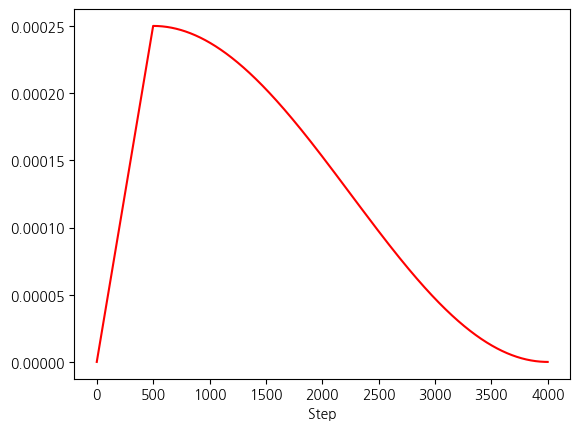

In [53]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [54]:
# Î™®Îç∏ ÏÉùÏÑ±
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 256),        4485632     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                            

In [55]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [56]:
# save weights callback  # 20Î∂Ñ
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
with tf.device('/GPU:0'):
    history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10


2000/2000 [==============================] - ETA: 0s - loss: 19.5877 - nsp_loss: 0.6503 - mlm_loss: 18.9374 - nsp_acc: 0.5901 - mlm_lm_acc: 0.1103
Epoch 1: mlm_lm_acc improved from -inf to 0.11035, saving model to ./bert_pretrain/models\bert_pre_train.hdf5
2000/2000 [==============================] - 236s 117ms/step - loss: 19.5877 - nsp_loss: 0.6503 - mlm_loss: 18.9374 - nsp_acc: 0.5901 - mlm_lm_acc: 0.1103
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 17.4683 - nsp_loss: 0.6242 - mlm_loss: 16.8440 - nsp_acc: 0.6182 - mlm_lm_acc: 0.1311
Epoch 2: mlm_lm_acc improved from 0.11035 to 0.13109, saving model to ./bert_pretrain/models\bert_pre_train.hdf5
2000/2000 [==============================] - 332s 166ms/step - loss: 17.4683 - nsp_loss: 0.6242 - mlm_loss: 16.8440 - nsp_acc: 0.6182 - mlm_lm_acc: 0.1311
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 15.8595 - nsp_loss: 0.6185 - mlm_loss: 15.2411 - nsp_acc: 0.6238 - mlm_lm_acc: 0.1548
Epoc

## 7.ÌîÑÎ°úÏ†ùÌä∏ Í≤∞Í≥º

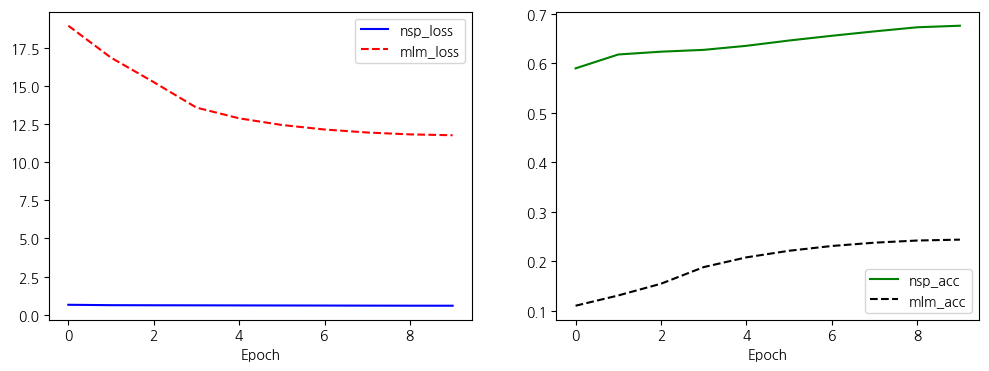

In [58]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

üßê mlm lossÎäî epochÍ∞Ä ÏßÑÌñâ Îê† ÏàòÎ°ù Ïûò Í∞êÏÜåÌïòÎäî Í≤ÉÏúºÎ°ú Î≥¥Ïù¥ÎäîÎç∞, nsp lossÎäî 0.65~0.58Î°ú Í∑∏Îã§ÏßÄ Î≥ÄÌôîÍ∞Ä ÏóÜÏñ¥Î≥¥ÏòÄÎã§. 
accuracyÎäî Îëò Îã§ ÏÉÅÏäπÌñàÎã§.  

# ÌöåÍ≥†

- np.memmapÏù¥ÎùºÎäî Ìï®ÏàòÎ•º Ï≤òÏùå Ïç®Î¥§Îã§. ÎåÄÏö©Îüâ Îç∞Ïù¥ÌÉÄÎ•º Î°úÎî© ÏãúÌÇ§Í∏∞ ÏúÑÌï¥ÏÑú Ïú†Ïö©ÌïòÍ≤å ÏÇ¨Ïö©Ìï† Ïàò ÏûàÍ≤†Îã§. 
- ÌååÎùºÎØ∏ÌÑ∞Í∞Ä ÎßûÏßÄ ÏïäÏïÑ ÏóêÎü¨Í∞Ä ÎÇòÏÑú Ï¢Ä Í≥†ÏÉùÏùÑ ÌñàÏßÄÎßå, Í∏àÎ∞© Ìï¥Í≤∞ÌñàÎã§. 
- TransformerÍ∏∞Î∞òÏùò BERTÎ•º ÏùµÌûàÍ∏∞Ïóê Ï¢ãÏùÄ ÏòàÏ†úÏòÄÎã§. 